# Tract assortativity

Here, the goal is to generate assortativity coefficients for every tract, in every cortical feature.


The notebook does the following: 

- for each tract and each cognitive term, compute an affinity matrix.
- use the tract mask to zero out pairs of regions that are not connected to the tract.
- the remaining correlations (i.e., in regions connected to the tract) are the aij value; and we also still have the activation values in the corresponding brain regions xi and xj. We can then compute an assortativity coefficient for this cognitive term and tract as `rx = sum(aij / 2m * (xi * xj))` (where 2m is the sum of the edge weights, for which will use the probability of connection - not sure yet exactly how - see how this is implemented in other papers).  
- this produces 12 (or whatever the number of cognitive terms is) assortativity coefficients per tract. Can then plot these as boxplots per tract, i.e. tracts (x) by ra (assortativity coefficient, y).
- can expect different tracts to be more or less assortative, e.g. depending on if they connect to regions that tend to have similar cognitive activations in different terms or not.

In [1]:
# let's import the needed packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
from neuromaps.datasets import fetch_fslr, fetch_annotation
from neuromaps import datasets, images, nulls, resampling, stats, transforms, parcellate
from surfplot import Plot
from neuromaps.parcellate import Parcellater, _gifti_to_array
from neuromaps.resampling import resample_images
from neuromaps.images import dlabel_to_gifti
import neuromaps
import nibabel as nib
import os
import numpy as np
import mayavi
from PIL import Image
import hcp_utils as hcp
import nilearn.plotting as plotting
import tractmaps_utils
import snf
from sklearn import cluster
from snf import metrics
from scipy import stats as sstats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Load data
Run the cortical features cell OR the neurosynth cell depending on which maps you want to run analyses on. 

In [3]:
### CORTICAL FEATURES DATA ###
analysis = 'cortex'
data = pd.read_csv('./inputs/tracts_maps_Glasser.csv')

In [2]:
### NEUROSYNTH DATA ###
analysis = 'neurosynth'
data = pd.read_csv('./inputs/tracts_neurosynth_Glasser.csv')

In [3]:
# set up inputs
maps_df = data.iloc[:, 59:]
maps_list = [maps_df[col].values for col in maps_df.columns]
map_names = list(maps_df)
glasser_maps = maps_df.to_dict(orient = 'list')
glasser_maps = {key: np.array(value) for key, value in glasser_maps.items()} # store parcellated maps as dictionary of map_names and arrays

## Compute assortativity coefficients

In [ ]:
import importlib
importlib.reload(tractmaps_utils)

In [5]:
# define inputs
tract_names = list(data.filter(regex = 'left|right').columns)
tract_names = [item for item in tract_names if item not in ['F_left', 'F_right']] # remove fornix (not used below)
nspins = 10000

### Compute nulls for all brain maps

First, we generate spun maps for all selected (cortical or neurosynth) annotations. 

Note: spins were the generated for all annotations, but were applied the in the same way for all different "networks", i.e. adjacency matrices in Vince's paper. So we'll do the same here: generate 10'000 spun maps for each included annotation; then use these to compute null assortativiy scores for each tract).

In [6]:
spins_dict = {}
n_features = len(map_names)  
glasser = tractmaps_utils.get_glasser() 
for iMap in range(n_features):
        
    # select brain map values
    map_name = map_names[iMap]

    # generate spins
    spins = nulls.alexander_bloch(data[map_name], atlas = 'fsLR', density = '32k', 
                                         n_perm = nspins, seed = 1234, parcellation = glasser)

    # save spins
    spins_dict[map_name] = spins
    
tractmaps_utils.save_data(spins_dict, f'./outputs/nulls/{analysis}_{nspins}spins.pickle')

###  Compute assortativity scores and significance testing

Next, we compute empirical assortativity scores using: 

* A: the adjacency matrix of each tract (which is a binary regions x regions matrix, where 1 indicates that both regions are connected to the 1, the rest as well as the lower triangle and diagonal is assigned to 0). 
* M: an array of annotation values in all brain regions. 

A and M are then used together to compute the assortativity coefficient for a given tract and annotation. As as result, we get an assortativity for all annotations in each tract. 

Significance testing is done by recomputing assortativity scores in 10'000 spun annotations (for each annotation and tract). 


In [76]:
# generate binary tract masks based on connection threshold
tract_masks = tractmaps_utils.generate_tract_masks(data, tract_names, connection_threshold = 0.95)

# load spin maps
spin_maps = tractmaps_utils.load_data(f'./outputs/nulls/{analysis}_{nspins}spins.pickle')
    
### --- Compute assortativity coefficients and null distributions for all tracts and brain maps --- ###
results = {}
for tract_name in tract_names:
    
#     print(f'computing assortativity coefficients for: `{tract_name}`')
    
    # initialize results dictionary for the tract
    results[tract_name] = {}
    
    # select tract mask
    tract_mask = tract_masks[tract_name]
    
    # subset data from brain regions of the hemisphere of the tract
    if 'left' in tract_name:
        hem_glasser_maps = {key: value[:180] for key, value in glasser_maps.items()}
        hem_spin_maps = {key: value[:180] for key, value in spin_maps.items()}

    elif 'right' in tract_name:
        hem_glasser_maps = {key: value[180:] for key, value in glasser_maps.items()}
        hem_spin_maps = {key: value[180:] for key, value in spin_maps.items()}
    
    for map_name, map_vals in glasser_maps.items():
        
#         print(f'computing scores for: `{map_name}`')
    
        # initialize results dictionary for annotation
        results[tract_name][map_name] = {}
        
        # assortativity with empirical annotations
        results[tract_name][map_name]['assort'] = tractmaps_utils.assortativity_coefficient(A = tract_masks[tract_name],
                                                                                            M = hem_glasser_maps[map_name]
                                                                                           )
        
        # get null annotations
        nulls = hem_spin_maps[map_name].T # to get spins (rows) x brain regions (columns)

        # assortativity with null annotations
        results[tract_name][map_name][f'assort_spin'] = tractmaps_utils.assort_null_batch(A = tract_masks[tract_name], 
                                                                                          M_all = nulls,
                                                                                          n_batch = 100
                                                                                         )

        # compute standardized assortativity + p-values
        results[tract_name][map_name]['assort_z'] = tractmaps_utils.standardize_scores(null = results[tract_name][map_name]['assort_spin'], 
                                                                                       emp = results[tract_name][map_name]['assort'],
                                                                                       ignore_nan = True
                                                                                      )
        results[tract_name][map_name]['assort_p'] = tractmaps_utils.get_p_value(null = results[tract_name][map_name]['assort_spin'],
                                                                                emp = results[tract_name][map_name]['assort']
                                                                               )

    # compute fdr-corrected p-values
    p_vals = [results[tract_name][map_name]['assort_p'] for map_name in results[tract_name]]
    _, p_fdr, _, _ = multipletests(p_vals, method = 'fdr_by')
    for n, map_name in enumerate(results[tract_name]):
        results[tract_name][map_name]['assort_p_fdr'] = p_fdr[n]

# save results 
tractmaps_utils.save_data(results, f'./outputs/assortativity/{analysis}_assortativity.pickle')

In [77]:


# Find indices where result_matrix has 1
row_indices, col_indices = np.where(tract_masks['UF_right'] == 1)

# Print the row and column indices
print("Row Indices with 1:", row_indices)
print("Column Indices with 1:", col_indices)

# tract_masks['OR_left'][:10, :10]

Row Indices with 1: [109 109 122]
Column Indices with 1: [122 130 130]


### Visualize empirical tract assortativity coefficients

All empirical assortativity coefficients are plotted for every tract. Significant assortativity coefficients (based on spin testing are highlighted in pink. 

In [78]:
import importlib
importlib.reload(tractmaps_utils)

<module 'tractmaps_utils' from '/Users/joelleba/neurohackademy/tractmaps/tractmaps_utils.py'>

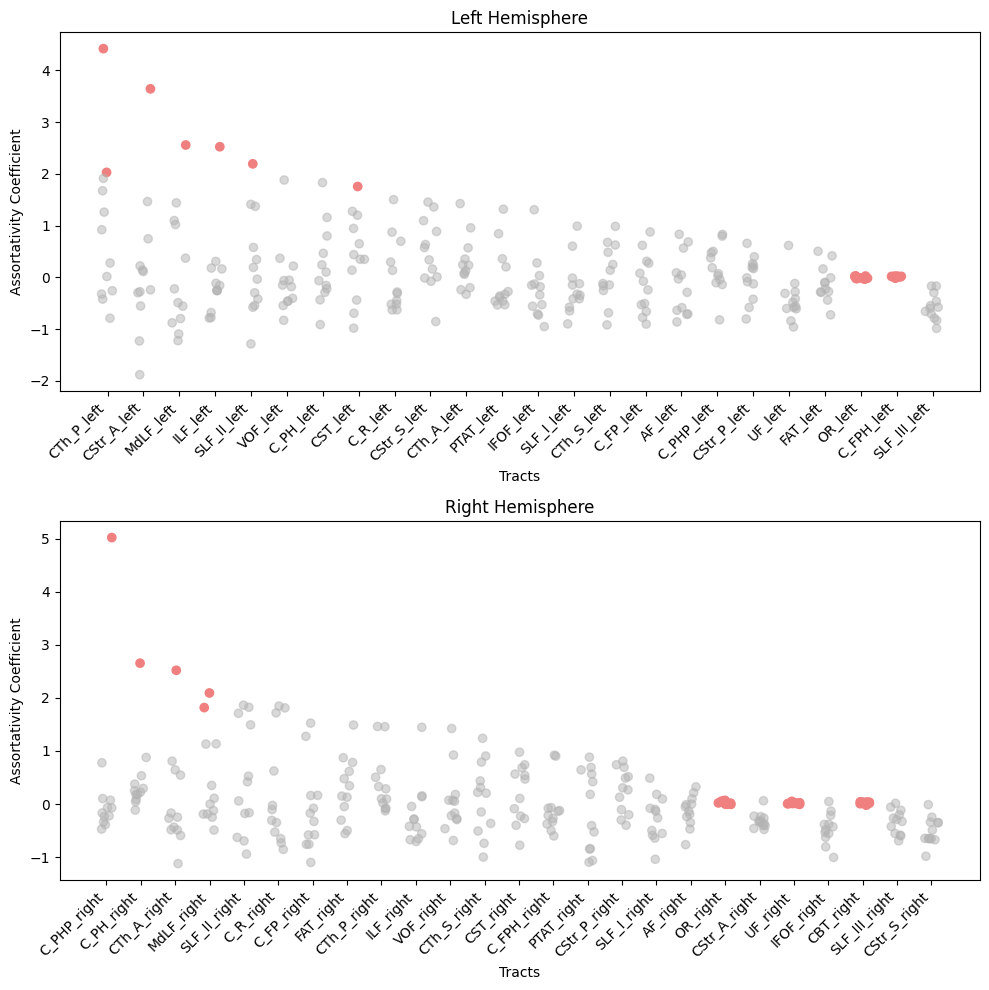

In [87]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(2, 1, figsize = (10, 10))

# Extract and plot left hemisphere tracts
left_tracts = []
for tract_name in results:
    if 'left' in tract_name.lower():
        map_results = results[tract_name]
        result_scores = [map_results[map_name]['assort_z'] for map_name in map_results]
        p_vals = [map_results[map_name]['assort_p'] for map_name in map_results]
        
         # Check if assort_z contains any NaN values
        if np.any(np.isnan(result_scores)):
            continue  # Skip tracts with NaN assort_z values

        max_result_score = np.max(result_scores)
        left_tracts.append((tract_name, max_result_score, result_scores, p_vals))
        

# Sort left hemisphere tracts by max_result_score
left_tracts.sort(key = lambda x: x[1], reverse = True)

# Call the plot function for the left hemisphere
tractmaps_utils.plot_tract_assort(left_tracts, 'Left', axes[0])

# Extract and plot right hemisphere tracts
right_tracts = []
for tract_name in results:
    if 'right' in tract_name.lower():
        map_results = results[tract_name]
        result_scores = [map_results[map_name]['assort_z'] for map_name in map_results]
        p_vals = [map_results[map_name]['assort_p'] for map_name in map_results]
        
        # Check if assort_z contains any NaN values
        if np.any(np.isnan(result_scores)):
            continue 
            
        max_result_score = np.max(result_scores)
        right_tracts.append((tract_name, max_result_score, result_scores, p_vals))

# Sort right hemisphere tracts by mean_result_score
right_tracts.sort(key = lambda x: x[1], reverse = True)

# Call the plot function for the right hemisphere
tractmaps_utils.plot_tract_assort(right_tracts, 'Right', axes[1])

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig(f'./outputs/assortativity/{analysis}_emp_assortativity.svg',
                bbox_inches = 'tight', dpi = 300,
                transparent = True)

### Visualize null distributions

Optionally, could use code here: https://github.com/netneurolab/bazinet_assortativity/blob/master/functions.py to generate boxplots showing empirical assortativity scores for let's say the top 3 tracts with the most significant assortativity scores. 

In [ ]:
# TODO: boxplot function that takes in a tract_name, its corresponding empirical assort and null assort values, and plots these for each annotation